_Author: Dana Chermesh Reshef, Director of Data and Innovation,DRAW Brooklyn_<br>
Novemeber 2019
# Zoning Analysis for visualizing housing and jobs densities
### _This analysis is done as a part of zoning analysis of Red Hook neighborhood, Brooklyn, in order to better assess and plan for jobs and housing creation. The output is a shapefile that would be imported to Grasshopper, Rhino to visualize densities as spatial components at their real location._

[PLUTO data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?r=19v1)

# Table of Content
0. [ Imports. ](#imp)
1. [ Data. ](#data)
2. [ Housing & Jobs creation by ZONING. ](#zoned)
3. [ Housing & Jobs creation by CURRENT USE and BUILT. ](#crnt)

<a name="imp"></a>
## 0. Imports

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib as plt
% pylab inline

import geopandas as gpd
import shapely
import fiona

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<a name="data"></a>
## 1. Data 
### 1.1 Data Obtaining
### Importing cropped MapPLUTO data from MapPLUTO / CARTO downloader
Source: https://chriswhong.github.io/plutoplus/ <br>
- Drew a polygon
- checked relevant data (columns) for download
- downloded a shapefile (saved in this folder under "data")

In [2]:
# reading in data into geodataframe
RH_pluto = gpd.GeoDataFrame.from_file('data/pluto_cropped/pluto.shp')
print('all columns downladed:\n', list(RH_pluto.columns), '\n')

# dropping two lots under "landmark" i.e Red Hook pool
RH_pluto = RH_pluto.drop(230)
RH_pluto = RH_pluto.drop(695)

# first cleaning of dataframe
RH_pluto['bbl'] = RH_pluto['bbl'].astype(int)
RH_pluto = RH_pluto.set_index('bbl')
RH_pluto = RH_pluto[['borough','block','lot','address','zipcode','zonedist1','zonedist2','overlay1',
                     'landuse','lotarea','lottype','assessland','assesstot','numbldgs','numfloors',
                     'bldgarea','builtfar','comarea', 'commfar','facilfar','factryarea','officearea',
                     'resarea','residfar','retailarea','otherarea', 'unitsres', 'unitstotal',
                     'xcoord', 'ycoord','geometry']]

print(RH_pluto.shape)
print(list(RH_pluto.columns), '\n')
RH_pluto.head()

all columns downladed:
 ['zonedist2', 'assessland', 'assesstot', 'bbl', 'bldgarea', 'block', 'borough', 'builtfar', 'comarea', 'commfar', 'facilfar', 'factryarea', 'histdist', 'landmark', 'landuse', 'lot', 'address', 'lottype', 'numbldgs', 'numfloors', 'officearea', 'otherarea', 'overlay1', 'overlay2', 'resarea', 'residfar', 'retailarea', 'unitsres', 'unitstotal', 'xcoord', 'ycoord', 'zipcode', 'zonedist1', 'lotarea', 'geometry'] 

(1107, 31)
['borough', 'block', 'lot', 'address', 'zipcode', 'zonedist1', 'zonedist2', 'overlay1', 'landuse', 'lotarea', 'lottype', 'assessland', 'assesstot', 'numbldgs', 'numfloors', 'bldgarea', 'builtfar', 'comarea', 'commfar', 'facilfar', 'factryarea', 'officearea', 'resarea', 'residfar', 'retailarea', 'otherarea', 'unitsres', 'unitstotal', 'xcoord', 'ycoord', 'geometry'] 



,borough,block,lot,address,zipcode,zonedist1,zonedist2,overlay1,landuse,lotarea,...,officearea,resarea,residfar,retailarea,otherarea,unitsres,unitstotal,xcoord,ycoord,geometry
bbl,,,,,,,,,,,,,,,,,,,,,
3005130037,BK,513,37,29 LUQUER STREET,11231,M1-1,,,02,2500,...,0,2822,0.00,0,0,3,3,983048,186654,POLYGON ((-74.00422686965121 40.67912249702655...
3005310033,BK,531,33,84 PIONEER STREET,11231,R5,,,01,1667,...,0,960,1.25,0,0,2,2,981598,186364,POLYGON ((-74.00941257100456 40.67829206929679...
3005970028,BK,597,28,VAN BRUNT STREET,11231,M1-1/R5,,,11,1725,...,0,0,1.25,0,0,0,0,980138,185559,POLYGON ((-74.01469712967557 40.67595358143477...
3005770022,BK,577,22,WOLCOTT STREET,11231,R5,,,11,2000,...,0,0,1.25,0,0,0,0,981272,185396,POLYGON ((-74.01058329319945 40.67563347172912...
3005550001,BK,555,1,CONOVER STREET,11231,M2-1,,,10,7500,...,0,0,0.00,0,0,0,0,980601,186539,POLYGON ((-74.01292718422793 40.67866661859882...


In [3]:
# geospatial munging
RH_pluto.crs

{'init': 'epsg:4326'}

In [4]:
RH_pluto = RH_pluto.to_crs({'init': 'epsg:2263'})
RH_pluto.crs

{'init': 'epsg:2263'}

### Test: simple geodataframe plotting

Text(0.5,1,'Red Hook, Brooklyn lots')

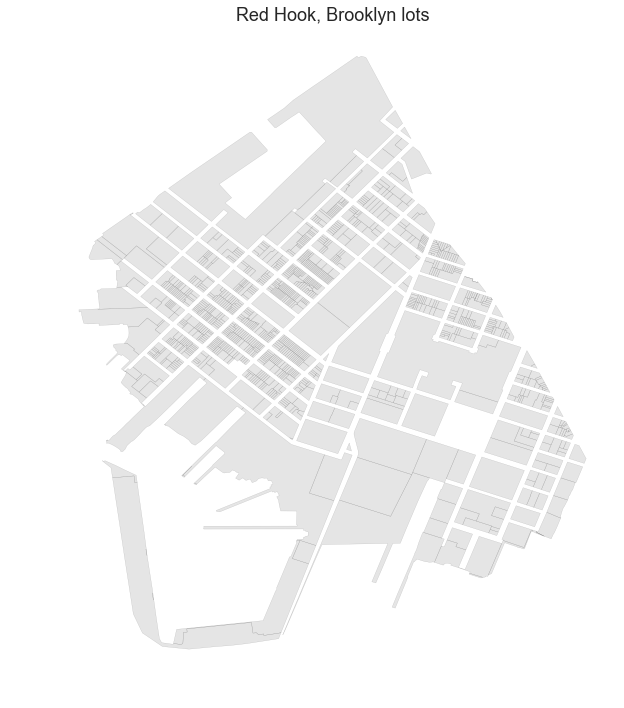

In [5]:
import seaborn
seaborn.set(style='ticks')

# try to plot
fig = plt.figure(figsize=(10,12)) 
ax = fig.add_subplot(111)
RH_pluto.plot(ax=ax,color='grey',edgecolor='k',alpha=0.2)
ax.axis('off')
ax.set_title('Red Hook, Brooklyn lots', fontsize=18)

## 1.2 Data exploration and preparation
## goal: creating z-value columns to be imported to Rhino+Grasshopper and visualized in 3D
- **phase 1**: create dummy heights via python dictionary
- **phase 2**: analyze zoning, land-uses and other factors to match heights
- **phase 3**: assess # of housing and jobs based on ALLOWED FAR + USE

In [6]:
RH_pluto['zonedist1'].unique()

array(['M1-1', 'R5', 'M1-1/R5', 'M2-1', 'M3-1', 'R6', 'M1-2', 'PARK', ''],
      dtype=object)

### ** Replacing "land-use" PLUTO code to their meaning according to [PLUTO NYC data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?r=19v1)

In [7]:
RH_pluto['landuse'].dtypes

dtype('O')

In [8]:
RH_pluto['landuse'] = RH_pluto['landuse'].replace('01', 'One & Two Family Buildings')
RH_pluto['landuse'] = RH_pluto['landuse'].replace('02', 'Multi-Family Walk-Up Buildings')
RH_pluto['landuse'] = RH_pluto['landuse'].replace('03', 'Multi-Family Elevator Buildings')
RH_pluto['landuse'] = RH_pluto['landuse'].replace('04', 'Mixed Residential & Commercial Buildings')
RH_pluto['landuse'] = RH_pluto['landuse'].replace('05', 'Commercial & Office Buildings')
RH_pluto['landuse'] = RH_pluto['landuse'].replace('06', 'Industrial & Manufacturing')
RH_pluto['landuse'] = RH_pluto['landuse'].replace('07', 'Transportation & Utility')
RH_pluto['landuse'] = RH_pluto['landuse'].replace('08', 'Public Facilities & Institutions')
RH_pluto['landuse'] = RH_pluto['landuse'].replace('09', 'Open Space & Outdoor Recreation')
RH_pluto['landuse'] = RH_pluto['landuse'].replace('10', 'Parking Facilities')
RH_pluto['landuse'] = RH_pluto['landuse'].replace('11', 'Vacant Land')


RH_pluto['landuse'].value_counts()

One & Two Family Buildings                  229
Industrial & Manufacturing                  220
Multi-Family Walk-Up Buildings              172
Vacant Land                                 128
Mixed Residential & Commercial Buildings    108
Parking Facilities                           77
                                             60
Commercial & Office Buildings                37
Public Facilities & Institutions             28
Transportation & Utility                     26
Open Space & Outdoor Recreation              15
Multi-Family Elevator Buildings               7
Name: landuse, dtype: int64

### # phase 1: create dummy heights via python dictionary
Will be used only for testing the Grasshopper algorithm


In [9]:
# phase 1: create dummy heights via python dictionary

# creating a function
def dummyZ(df):
    if df['zonedist1'] == 'M1-1':
        val = 25
    elif df['zonedist1'] == 'R5':
        val = 40
    elif df['zonedist1'] == 'M1-1/R5':
        val = 60
    elif df['zonedist1'] == 'M2-1':
        val = 175
    elif df['zonedist1'] == 'M3-1':
        val = 300
    elif df['zonedist1'] == 'R6':
        val = 70
    elif df['zonedist1'] == 'PARK':
        val = 0
    else:
        val = 0
    return val

RH_pluto['dummy_Zvalues'] = RH_pluto.apply(dummyZ, axis=1)

print(RH_pluto.shape)
RH_pluto[['zonedist1', 'dummy_Zvalues']].head()

(1107, 32)


,zonedist1,dummy_Zvalues
bbl,,
3005130037,M1-1,25
3005310033,R5,40
3005970028,M1-1/R5,60
3005770022,R5,40
3005550001,M2-1,175


In [10]:
RH_pluto.iloc[:3,-2:]

,geometry,dummy_Zvalues
bbl,,
3005130037,"POLYGON ((983077.6030546736 186699.0820321986,...",25
3005310033,"POLYGON ((981639.2246978442 186396.6453011248,...",40
3005970028,"POLYGON ((980173.2978396735 185544.8687894511,...",60


----
----
<a name="zoned"></a>
## 2. Assessing # of housing and jobs creation according to zoning, landuse and ALLOWED FAR 
#### from Alex+Dana meeting 20191108:
- goals: jobs and housing visualize
- zoning analysis: (not current)
- no. jobs per lot + no. housing per lot
- FAR Resi allowed * lot size 
- FAR M allowed * lot size / ## for warehouse OR / ## for retail OR / ## for office

> then visualize: 1 foot for 1 job, etc; 1 foot for 1 housing unit (different colors)
- optional: translate to ppl? (live/work)


### 2.1 Data munging

In [11]:
# checking for correspondance between "..area" and "..far" to understand if they relate to existing / allowed numbers

RH_pluto[['address','zonedist1','landuse','comarea', 'commfar','facilfar','factryarea',
          'officearea','resarea','residfar','retailarea','otherarea', 'geometry']].head()

,address,zonedist1,landuse,comarea,commfar,facilfar,factryarea,officearea,resarea,residfar,retailarea,otherarea,geometry
bbl,,,,,,,,,,,,,
3005130037,29 LUQUER STREET,M1-1,Multi-Family Walk-Up Buildings,0,1.0,2.4,0,0,2822,0.00,0,0,"POLYGON ((983077.6030546736 186699.0820321986,..."
3005310033,84 PIONEER STREET,R5,One & Two Family Buildings,0,0.0,2.0,0,0,960,1.25,0,0,"POLYGON ((981639.2246978442 186396.6453011248,..."
3005970028,VAN BRUNT STREET,M1-1/R5,Vacant Land,0,1.0,2.0,0,0,0,1.25,0,0,"POLYGON ((980173.2978396735 185544.8687894511,..."
3005770022,WOLCOTT STREET,R5,Vacant Land,0,0.0,2.0,0,0,0,1.25,0,0,"POLYGON ((981314.3831559267 185428.0789967846,..."
3005550001,CONOVER STREET,M2-1,Parking Facilities,0,2.0,0.0,0,0,0,0.00,0,0,"POLYGON ((980664.3926580118 186533.2286893559,..."


#### *We can see that the "area" columns and the "far" columns per use are not aligned; thus we can infer that the "area" means the _current SF for that use_ and that "far" reflects the _ALLOWED far for that use_. We will analyze both in two different tables.

### More info from [PLUTO data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?r=19v1):
- **COMMERCIAL FLOOR AREA (ComArea)** == An estimate of the exterior dimensions of the portion of the structure(s) allocated for commercial use.<br>
Value is taken from PTS, if available. When calculated from PTS data, **COMMERCIAL FLOOR AREA** is the **sum of floor areas for office, retail, garage, storage, factory, and other uses**.

### _This means that we can NEGLECT calculations for retailarea, factryarea, garagearea, otherarea, storagearea.... as they are all counted under 'comarea'; we will refer to this value + resiarea_

In [12]:
# creating a new shortened dataframe for current SF by use and for allowed FAR by use

RH_areas_by_use = RH_pluto[['address','zonedist1','landuse','overlay1',
                            'comarea','resarea','geometry']] #leaving geometry to remain geodataframe

RH_allowed_far = RH_pluto[['address','lotarea','zonedist1','landuse','overlay1',
                           'commfar','residfar','geometry']] #leaving geometry to remain geodataframe 
                                                             # dropped 'facilfar' 20191118

print('RH_areas_by_use.shape: ', RH_areas_by_use.shape)
RH_areas_by_use.head(6)

RH_areas_by_use.shape:  (1107, 7)


,address,zonedist1,landuse,overlay1,comarea,resarea,geometry
bbl,,,,,,,
3005130037,29 LUQUER STREET,M1-1,Multi-Family Walk-Up Buildings,,0,2822,"POLYGON ((983077.6030546736 186699.0820321986,..."
3005310033,84 PIONEER STREET,R5,One & Two Family Buildings,,0,960,"POLYGON ((981639.2246978442 186396.6453011248,..."
3005970028,VAN BRUNT STREET,M1-1/R5,Vacant Land,,0,0,"POLYGON ((980173.2978396735 185544.8687894511,..."
3005770022,WOLCOTT STREET,R5,Vacant Land,,0,0,"POLYGON ((981314.3831559267 185428.0789967846,..."
3005550001,CONOVER STREET,M2-1,Parking Facilities,,0,0,"POLYGON ((980664.3926580118 186533.2286893559,..."
3005870001,VAN BRUNT STREET,R5,Vacant Land,C1-3,0,0,"POLYGON ((980432.0798024287 185621.3145027092,..."


In [13]:
print('# of lots with commercial overlay:', RH_areas_by_use[RH_areas_by_use['overlay1'] != ''].shape[0])
print('# of lots with commerce area larger than 0:', RH_areas_by_use[RH_areas_by_use['comarea'] != 0].shape[0], '\n')

RH_areas_by_use[RH_areas_by_use['comarea'] != 0].head(10)

# of lots with commercial overlay: 174
# of lots with commerce area larger than 0: 475 



,address,zonedist1,landuse,overlay1,comarea,resarea,geometry
bbl,,,,,,,
3005800016,76 LORRAINE STREET,R5,Public Facilities & Institutions,C1-3,21000,0,"POLYGON ((982402.3110981762 184922.1088801185,..."
3005350001,767 HICKS STREET,M1-1,Industrial & Manufacturing,,4480,0,"POLYGON ((983053.8435877573 185840.8429350285,..."
3005770001,183 RICHARDS STREET,R5,Mixed Residential & Commercial Buildings,,1500,1800,"POLYGON ((981037.7029350135 185435.7472885243,..."
3005870010,365 VAN BRUNT STREET,R5,Mixed Residential & Commercial Buildings,C1-3,960,1920,"POLYGON ((980530.1501443429 185779.0664837834,..."
3005120001,12 COMMERCE STREET,M1-1,Industrial & Manufacturing,,8555,0,"POLYGON ((982657.4195118393 186883.9750351208,..."
3005460010,291 VAN BRUNT STREET,R5,Mixed Residential & Commercial Buildings,C1-3,1199,2547,"POLYGON ((981243.4390720924 186536.9927894446,..."
3004950001,659 SMITH STREET,M3-1,Industrial & Manufacturing,,40000,0,"POLYGON ((984282.8355523373 183186.3912229452,..."
3005560007,317 VAN BRUNT STREET,R5,Mixed Residential & Commercial Buildings,C1-3,998,3162,"POLYGON ((981028.7748032506 186311.0168634534,..."
3006210050,757 CLINTON STREET,M3-1,Industrial & Manufacturing,,16845,0,"POLYGON ((983306.9956405036 183147.2354613757,..."


### Allowed FAR data explenations from [PLUTO data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?r=19v1):
- **MAXIMUM ALLOWABLE RESIDENTIAL FAR (ResidFAR)** == _Data Source:_ **Department of City Planning Zoning Division**
_Description:_ The maximum allowable residential floor area ratio, based on the zoning district classification occupying the greatest percentage of the tax lot’s area as reported in **ZoneDist1**. If the lot is assigned to more than one zoning district and ZoneDist1 does not allow residential uses, MAXIMUM ALLOWABLE RESIDENTIAL FAR is based on **ZoneDist2, ZoneDist3 or ZoneDist4, in that order.** <br> 
**For properties zoned R6, ResidFAR reflects the maximum achievable floor area under ideal conditions.** <br> 
The maximum allowable floor area **does not reflect Voluntary Inclusionary Housing
or Mandatory Inclusionary Housing Program floor area**. See [Appendix F](https://zr.planning.nyc.gov/appendix-f-inclusionary-housing-designated-areas-and-mandatory-inclusionary-housing-areas) and [Section 23-154, paragraphs (b) and (d) of the Zoning Resolution](https://zr.planning.nyc.gov/article-ii/chapter-3/23-154).  <br> 
For properties in **special mixed use districts**, PLUTO uses the **wide street maximum allowable floor area ratio**. Since the maximum allowable floor area ratio in mixed use special districts is actually determined by whether the property is located on a wide street or a narrow street, users should consult [Section 23-153 of the Zoning Resolution](https://zr.planning.nyc.gov/article-ii/chapter-3/23-153). 

- **MAXIMUM ALLOWABLE COMMERCIAL FAR (CommFAR)** == _Data Source:_ **Department of City Planning Zoning Division**
_Description:_ The maximum allowable commercial floor area ratio, based on the zoning district classification occupying the greatest percentage of the tax lot’s area as reported in **ZoneDist1**. If the lot is assigned to more than one zoning district and ZoneDist1 does not allow commercial uses, MAXIMUM ALLOWABLE COMMERCIAL FAR is based on **ZoneDist2, ZoneDist3 or ZoneDist4, in that order**. <br>
_Users should consult [Section 43-12 of the Zoning Resolution](https://zr.planning.nyc.gov/article-iv/chapter-3/43-12) for more information._

- **MAXIMUM ALLOWABLE COMMUNITY FACILITY FAR (FacilFAR)** == _Data Source:_ **Department of City Planning Zoning Division**
_Description:_ The maximum allowable community facility floor area ratio, based on the zoning district classification occupying the greatest percentage of the tax lot’s area as reported in **ZoneDist1**. If the lot is assigned to more than one zoning district and ZoneDist1 does not allow community facility uses, MAXIMUM ALLOWABLE COMMUNITY FACILITY FAR is based on **ZoneDist2, ZoneDist3 or ZoneDist4, in
that order**. <br>
_Users should consult [Section 24-11 of the Zoning Resolution](https://zr.planning.nyc.gov/article-ii/chapter-4/24-11) for more information_

In [14]:
print('RH_allowed_far.shape: ', RH_allowed_far.shape)
RH_allowed_far.head(10)

RH_allowed_far.shape:  (1107, 8)


,address,lotarea,zonedist1,landuse,overlay1,commfar,residfar,geometry
bbl,,,,,,,,
3005130037,29 LUQUER STREET,2500,M1-1,Multi-Family Walk-Up Buildings,,1.0,0.00,"POLYGON ((983077.6030546736 186699.0820321986,..."
3005310033,84 PIONEER STREET,1667,R5,One & Two Family Buildings,,0.0,1.25,"POLYGON ((981639.2246978442 186396.6453011248,..."
3005970028,VAN BRUNT STREET,1725,M1-1/R5,Vacant Land,,1.0,1.25,"POLYGON ((980173.2978396735 185544.8687894511,..."
3005770022,WOLCOTT STREET,2000,R5,Vacant Land,,0.0,1.25,"POLYGON ((981314.3831559267 185428.0789967846,..."
3005550001,CONOVER STREET,7500,M2-1,Parking Facilities,,2.0,0.00,"POLYGON ((980664.3926580118 186533.2286893559,..."
3005870001,VAN BRUNT STREET,1500,R5,Vacant Land,C1-3,0.0,1.25,"POLYGON ((980432.0798024287 185621.3145027092,..."
3005460007,297 VAN BRUNT STREET,1219,R5,Vacant Land,C1-3,0.0,1.25,"POLYGON ((981205.1094243403 186494.5099347805,..."
3005760051,88 DIKEMAN STREET,2000,R5,Multi-Family Walk-Up Buildings,,0.0,1.25,"POLYGON ((980782.9747699215 185765.8178226011,..."
3005870052,106 COFFEY STREET,2200,R5,Vacant Land,C1-3,0.0,1.25,"POLYGON ((980515.2889535864 185654.4601057032,..."


In [15]:
# ALEX's
RH_allowed_far[RH_allowed_far['address'] == '373 VAN BRUNT STREET']

,address,lotarea,zonedist1,landuse,overlay1,commfar,residfar,geometry
bbl,,,,,,,,
3005870005,373 VAN BRUNT STREET,1900,R5,Mixed Residential & Commercial Buildings,C1-3,0.0,1.25,"POLYGON ((980496.9858405926 185670.811450942, ..."


### Adding 1 FAR for every C1-3 overlay
ignored / dropped 'facilfar'; 20191118

In [16]:
# adding 1 FAR for every C1-3 overlay
print(RH_allowed_far[RH_allowed_far['overlay1'] != ''].shape)

RH_allowed_far['commfarNEW'] = np.where((RH_allowed_far['overlay1'] == ''),
                               RH_allowed_far['commfar'], np.where((RH_allowed_far['commfar'] == 0.0), 1.0, 0.0))

RH_allowed_far[['zonedist1','overlay1', 'commfar', 'commfarNEW']].head(15)

(174, 8)


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,zonedist1,overlay1,commfar,commfarNEW
bbl,,,,
3005130037,M1-1,,1.0,1.0
3005310033,R5,,0.0,0.0
3005970028,M1-1/R5,,1.0,1.0
3005770022,R5,,0.0,0.0
3005550001,M2-1,,2.0,2.0
3005870001,R5,C1-3,0.0,1.0
3005460007,R5,C1-3,0.0,1.0
3005760051,R5,,0.0,0.0
3005870052,R5,C1-3,0.0,1.0


In [31]:
# calculating ALLOWED SF per use (MAXIMUM FAR * lotarea)
RH_allowed_far['maxComm'] = RH_allowed_far['commfarNEW'] * RH_allowed_far['lotarea'] 
# RH_allowed_far['maxFacil'] = RH_allowed_far['facilfar'] * RH_allowed_far['lotarea'] # dropped facilfar 20191118
RH_allowed_far['maxResi'] = RH_allowed_far['residfar'] * RH_allowed_far['lotarea'] 

RH_allowed_far.head(8)

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,address,lotarea,zonedist1,landuse,overlay1,commfar,residfar,geometry,commfarNEW,maxComm,maxResi
bbl,,,,,,,,,,,
3005130037,29 LUQUER STREET,2500,M1-1,Multi-Family Walk-Up Buildings,,1.0,0.00,"POLYGON ((983077.6030546736 186699.0820321986,...",1.0,2500.0,0.00
3005310033,84 PIONEER STREET,1667,R5,One & Two Family Buildings,,0.0,1.25,"POLYGON ((981639.2246978442 186396.6453011248,...",0.0,0.0,2083.75
3005970028,VAN BRUNT STREET,1725,M1-1/R5,Vacant Land,,1.0,1.25,"POLYGON ((980173.2978396735 185544.8687894511,...",1.0,1725.0,2156.25
3005770022,WOLCOTT STREET,2000,R5,Vacant Land,,0.0,1.25,"POLYGON ((981314.3831559267 185428.0789967846,...",0.0,0.0,2500.00
3005550001,CONOVER STREET,7500,M2-1,Parking Facilities,,2.0,0.00,"POLYGON ((980664.3926580118 186533.2286893559,...",2.0,15000.0,0.00
3005870001,VAN BRUNT STREET,1500,R5,Vacant Land,C1-3,0.0,1.25,"POLYGON ((980432.0798024287 185621.3145027092,...",1.0,1500.0,1875.00
3005460007,297 VAN BRUNT STREET,1219,R5,Vacant Land,C1-3,0.0,1.25,"POLYGON ((981205.1094243403 186494.5099347805,...",1.0,1219.0,1523.75
3005760051,88 DIKEMAN STREET,2000,R5,Multi-Family Walk-Up Buildings,,0.0,1.25,"POLYGON ((980782.9747699215 185765.8178226011,...",0.0,0.0,2500.00


## 2.2 HYPOTHESES: "WHAT IF" scenarios for planning
### 2.2.1 Jobs creation
Based on: [Measuring Employment report](https://metrocouncil.org/Handbook/Files/Resources/Fact-Sheet/ECONOMIC-COMPETITIVENESS/How-to-Measure-Employment-Intensity-and-Capacity.aspx) and [eia.gov](https://www.eia.gov/consumption/commercial/data/2012/bc/cfm/b2.php)
- scenario #1: all that is not-resi >> WAREHOUSE 1 job / 3000 SF
- scenario #2: is not-resi >> INDUSTRIAL/RETAIL 1 job / 600 SF
- scenario #3: not-resi >> MAKERS/OFFICE 1 job / 200 SF

In [32]:
RH_jobs = RH_allowed_far[['address', 'lotarea', 'zonedist1', 'landuse', 
                          'overlay1', 'maxComm', 'maxResi', 'geometry']]

# calculating # of jobs for warehousing; 1 job / 3000 
RH_jobs['WAREHOUSES'] = (RH_jobs['maxComm'] / 3000).astype(int)
# calculating # of jobs for industrial; 1 job / 600 
RH_jobs['INDUSTRIAL/RETAIL'] = (RH_jobs['maxComm'] / 600).astype(int)
# calculating # of jobs for makers space / office; 1 job / 200 
RH_jobs['MAKERS/OFFICE'] = (RH_jobs['maxComm'] / 200).astype(int)

#Total sum per column: 
RH_jobs = RH_jobs.reset_index()
RH_jobs = RH_jobs.append(RH_jobs.sum(axis=0, numeric_only=True), ignore_index=True)
RH_jobs['bbl'] = RH_jobs['bbl'].astype(int).astype(str)
RH_jobs.at[1107, 'bbl'] = 'TOTAL'
RH_jobs = RH_jobs.set_index('bbl')
RH_jobs.iloc[-1:,:] = RH_jobs.iloc[-1:,:].fillna(0).astype(int)

print(RH_jobs.shape)
RH_jobs[['address','lotarea','zonedist1','landuse','overlay1','maxComm',
         'WAREHOUSES','INDUSTRIAL/RETAIL','MAKERS/OFFICE']].head(10)

(1108, 11)


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,address,lotarea,zonedist1,landuse,overlay1,maxComm,WAREHOUSES,INDUSTRIAL/RETAIL,MAKERS/OFFICE
bbl,,,,,,,,,
3005130037,29 LUQUER STREET,2500.0,M1-1,Multi-Family Walk-Up Buildings,,2500.0,0.0,4.0,12.0
3005310033,84 PIONEER STREET,1667.0,R5,One & Two Family Buildings,,0.0,0.0,0.0,0.0
3005970028,VAN BRUNT STREET,1725.0,M1-1/R5,Vacant Land,,1725.0,0.0,2.0,8.0
3005770022,WOLCOTT STREET,2000.0,R5,Vacant Land,,0.0,0.0,0.0,0.0
3005550001,CONOVER STREET,7500.0,M2-1,Parking Facilities,,15000.0,5.0,25.0,75.0
3005870001,VAN BRUNT STREET,1500.0,R5,Vacant Land,C1-3,1500.0,0.0,2.0,7.0
3005460007,297 VAN BRUNT STREET,1219.0,R5,Vacant Land,C1-3,1219.0,0.0,2.0,6.0
3005760051,88 DIKEMAN STREET,2000.0,R5,Multi-Family Walk-Up Buildings,,0.0,0.0,0.0,0.0
3005870052,106 COFFEY STREET,2200.0,R5,Vacant Land,C1-3,2200.0,0.0,3.0,11.0


In [33]:
print('Number of jobs created under the scenarios:\n\n', RH_jobs.iloc[-1:,-3:-2],
     '\n\n', RH_jobs.iloc[-1:,-2:-1],'\n\n', RH_jobs.iloc[-1:,-1:])

Number of jobs created under the scenarios:

        WAREHOUSES
bbl              
TOTAL     10085.0 

        INDUSTRIAL/RETAIL
bbl                     
TOTAL            52091.0 

        MAKERS/OFFICE
bbl                 
TOTAL       157056.0


----
### 2.2.2 Housing creation

- ave housing unit per SF for R5: 1 housing unit / 760 SF

In [34]:
RH_housing = RH_allowed_far[['address', 'zonedist1','landuse', 
                             'overlay1','maxResi','geometry']]

# calculating # of housing units; 1 housing unit / 760 SF
RH_housing['HOUSING UNITS'] = (RH_housing['maxResi'] / 760).astype(int)
# calculating # of residents; 1 housing unit * 2.73 ppl
RH_housing['RESIDENTS (PPL)'] = (RH_housing['HOUSING UNITS'] * 2.73).astype(int)

#Total sum per column: 
RH_housing = RH_housing.reset_index()
RH_housing = RH_housing.append(RH_housing.sum(axis=0, numeric_only=True), ignore_index=True)
RH_housing['bbl'] = RH_housing['bbl'].astype(int).astype(str)
RH_housing.at[1107, 'bbl'] = 'TOTAL'
RH_housing = RH_housing.set_index('bbl')
RH_housing.iloc[-1:,:] = RH_housing.iloc[-1:,:].fillna(0).astype(int)

print(RH_housing.shape)
RH_housing.tail(10)

(1108, 8)


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,address,zonedist1,landuse,overlay1,maxResi,geometry,HOUSING UNITS,RESIDENTS (PPL)
bbl,,,,,,,,
3005450025,334 VAN BRUNT STREET,R5,Parking Facilities,C1-3,1886.25,"POLYGON ((981038.8541794273 186515.3133708654,...",2.0,5.0
3005750037,134 DIKEMAN STREET,R5,Multi-Family Walk-Up Buildings,,3125.00,"POLYGON ((980371.9365500107 186131.8820511159,...",4.0,10.0
3005780004,133 DWIGHT STREET,M1-1,Industrial & Manufacturing,,0.00,"POLYGON ((981513.7098570014 185133.7081944564,...",0.0,0.0
3005990010,55 COFFEY STREET,M1-1,Industrial & Manufacturing,,0.00,"POLYGON ((980865.9877272542 185130.0589235295,...",0.0,0.0
3005220004,245 VAN BRUNT STREET,M1-1,Industrial & Manufacturing,,0.00,"POLYGON ((981710.9030321679 187028.6341946178,...",0.0,0.0
3005260016,62 NELSON STREET,M1-1,Multi-Family Walk-Up Buildings,,0.00,"POLYGON ((983298.1104876709 186193.4301563669,...",0.0,0.0
3005460031,89 PIONEER STREET,R5,One & Two Family Buildings,,1562.50,"POLYGON ((981508.4388701766 186301.3938511921,...",2.0,5.0
3005560116,115A KING STREET,R5,One & Two Family Buildings,,2103.75,"POLYGON ((981172.7853420075 186251.3070091214,...",2.0,5.0
3005310041,100 PIONEER STREET,R5,One & Two Family Buildings,,2083.75,"POLYGON ((981538.8846754297 186486.1536522833,...",2.0,5.0


## 2.3 Exporting to .shp for grasshopper import and rhino visualization:
using Meerkat plugin 
https://www.food4rhino.com/app/meerkat-gis

In [35]:
# combining jobs and housing datasets for easier use in grasshopper

RH_scenarios1118 = RH_jobs.merge(RH_housing.iloc[:,-2:], left_index=True, right_index=True)[:-1]
print(RH_scenarios1118.shape)
RH_scenarios1118.tail(30)

(1107, 13)


,address,lotarea,zonedist1,landuse,overlay1,maxComm,maxResi,geometry,WAREHOUSES,INDUSTRIAL/RETAIL,MAKERS/OFFICE,HOUSING UNITS,RESIDENTS (PPL)
bbl,,,,,,,,,,,,,
3005767501,180 RICHARDS STREET,2480.0,R5,Multi-Family Walk-Up Buildings,,0.0,3100.00,"POLYGON ((980978.6987879272 185671.283890945, ...",0.0,0.0,0.0,4.0,10.0
3005180026,,0.0,,,,0.0,0.00,"POLYGON ((982210.569027593 186986.9430050279, ...",0.0,0.0,0.0,0.0,0.0
3005260019,66 NELSON STREET,2550.0,M1-1,Multi-Family Walk-Up Buildings,,2550.0,0.00,"POLYGON ((983345.9903131725 186175.9095221257,...",0.0,4.0,12.0,0.0,0.0
3005170024,232 VAN BRUNT STREET,990.0,M2-1,Parking Facilities,,1980.0,0.00,"POLYGON ((981811.1190390923 187374.4320594533,...",0.0,3.0,9.0,0.0,0.0
3005780008,129 DWIGHT STREET,4270.0,M1-1,Commercial & Office Buildings,,4270.0,0.00,"POLYGON ((981522.8518990914 185158.579863858, ...",1.0,7.0,21.0,0.0,0.0
3005520022,348 HAMILTON AVENUE,1140.0,M1-1,Commercial & Office Buildings,,1140.0,0.00,"POLYGON ((984116.3723025946 184954.3502854382,...",0.0,1.0,5.0,0.0,0.0
3006070001,558 COLUMBIA STREET,152165.0,PARK,Open Space & Outdoor Recreation,,0.0,0.00,"POLYGON ((981815.6229670984 184333.4814484475,...",0.0,0.0,0.0,0.0,0.0
3005157501,160 IMLAY STREET,61500.0,M2-1,Mixed Residential & Commercial Buildings,,123000.0,0.00,"POLYGON ((981312.4317162655 187166.0184342903,...",41.0,205.0,615.0,0.0,0.0
3005980018,89 COFFEY STREET,3000.0,M1-1,Public Facilities & Institutions,,3000.0,0.00,"POLYGON ((980517.7587649241 185439.4372417782,...",1.0,5.0,15.0,0.0,0.0


In [36]:
# export a .shp in order to import it into Grasshopper and Rhino using Meerkat plugin 
# https://www.food4rhino.com/app/meerkat-gis
# unhush to export
RH_scenarios1118.to_file("RH_scenarios_1118.shp")

-----

-----

<a name="crnt"></a>
## 3. Assessing CURRENT jobs and housing based on zoning, land use and built FAR

In [23]:
# looking at the specific data relevant to this calculations
print(RH_pluto[['lotarea','zonedist1','overlay1','landuse','numfloors','numbldgs','bldgarea','builtfar']].dtypes, '\n')
RH_pluto[['lotarea','zonedist1','overlay1','landuse','numfloors','numbldgs','bldgarea','builtfar']].head(10)

lotarea        int64
zonedist1     object
overlay1      object
landuse       object
numfloors    float64
numbldgs       int64
bldgarea       int64
builtfar     float64
dtype: object 



,lotarea,zonedist1,overlay1,landuse,numfloors,numbldgs,bldgarea,builtfar
bbl,,,,,,,,
3005130037,2500,M1-1,,Multi-Family Walk-Up Buildings,3.0,1,2822,1.13
3005310033,1667,R5,,One & Two Family Buildings,2.0,2,960,0.58
3005970028,1725,M1-1/R5,,Vacant Land,0.0,0,0,0.00
3005770022,2000,R5,,Vacant Land,0.0,0,0,0.00
3005550001,7500,M2-1,,Parking Facilities,0.0,0,0,0.00
3005870001,1500,R5,C1-3,Vacant Land,0.0,0,0,0.00
3005460007,1219,R5,C1-3,Vacant Land,0.0,0,0,0.00
3005760051,2000,R5,,Multi-Family Walk-Up Buildings,3.0,1,2340,1.17
3005870052,2200,R5,C1-3,Vacant Land,0.0,0,0,0.00


In [24]:
#creating dataframe of columns of interest
RH_currentAreas =  RH_pluto[['address','zonedist1','overlay1','landuse',
                             'builtfar','numfloors','numbldgs','bldgarea',
                             'comarea','resarea','geometry']] #leaving geometry to remain geodataframe

print(RH_currentAreas.shape)
RH_currentAreas.head(7)

(1107, 11)


,address,zonedist1,overlay1,landuse,builtfar,numfloors,numbldgs,bldgarea,comarea,resarea,geometry
bbl,,,,,,,,,,,
3005130037,29 LUQUER STREET,M1-1,,Multi-Family Walk-Up Buildings,1.13,3.0,1,2822,0,2822,"POLYGON ((983077.6030546736 186699.0820321986,..."
3005310033,84 PIONEER STREET,R5,,One & Two Family Buildings,0.58,2.0,2,960,0,960,"POLYGON ((981639.2246978442 186396.6453011248,..."
3005970028,VAN BRUNT STREET,M1-1/R5,,Vacant Land,0.00,0.0,0,0,0,0,"POLYGON ((980173.2978396735 185544.8687894511,..."
3005770022,WOLCOTT STREET,R5,,Vacant Land,0.00,0.0,0,0,0,0,"POLYGON ((981314.3831559267 185428.0789967846,..."
3005550001,CONOVER STREET,M2-1,,Parking Facilities,0.00,0.0,0,0,0,0,"POLYGON ((980664.3926580118 186533.2286893559,..."
3005870001,VAN BRUNT STREET,R5,C1-3,Vacant Land,0.00,0.0,0,0,0,0,"POLYGON ((980432.0798024287 185621.3145027092,..."
3005460007,297 VAN BRUNT STREET,R5,C1-3,Vacant Land,0.00,0.0,0,0,0,0,"POLYGON ((981205.1094243403 186494.5099347805,..."


In [25]:
# how many lots have more than 1 bldg?
print(RH_currentAreas[RH_currentAreas['numbldgs'] > 1].shape[0])
RH_currentAreas[RH_currentAreas['numbldgs'] > 1].head()

169


,address,zonedist1,overlay1,landuse,builtfar,numfloors,numbldgs,bldgarea,comarea,resarea,geometry
bbl,,,,,,,,,,,
3005310033,84 PIONEER STREET,R5,,One & Two Family Buildings,0.58,2.0,2,960,0,960,"POLYGON ((981639.2246978442 186396.6453011248,..."
3005390008,769 HICKS STREET,R5,C1-2,Multi-Family Walk-Up Buildings,0.88,2.0,2,2208,0,2208,"POLYGON ((983041.6044390062 185752.7197517011,..."
3005830023,218 LORRAINE STREET,M1-1,,,0.00,0.0,4,0,0,0,"POLYGON ((983946.7394397586 184354.1083756966,..."
3005310048,114 PIONEER STREET,R5,,One & Two Family Buildings,0.72,2.0,2,1200,0,1200,"POLYGON ((981451.9960696714 186563.6626836145,..."
3005120001,12 COMMERCE STREET,M1-1,,Industrial & Manufacturing,0.95,2.0,5,8555,8555,0,"POLYGON ((982657.4195118393 186883.9750351208,..."


#### Analyzing FAR values in our area of interest

In [26]:
print("number of lots with FAR == 0 is: {}".format(RH_currentAreas[RH_currentAreas['builtfar'] == 0].shape[0]))
print("number of lots with FAR > 1 is: {}".format(RH_currentAreas[RH_currentAreas['builtfar'] > 1].shape[0]))
print("number of lots with FAR > 2 is: {}".format(RH_currentAreas[RH_currentAreas['builtfar'] > 2].shape[0]))
print("number of lots with FAR > 3 is: {}".format(RH_currentAreas[RH_currentAreas['builtfar'] > 3].shape[0]))
print("number of lots with FAR > 4 is: {}".format(RH_currentAreas[RH_currentAreas['builtfar'] > 4].shape[0]))
print("number of lots with FAR > 5 is: {}".format(RH_currentAreas[RH_currentAreas['builtfar'] > 5].shape[0]))

number of lots with FAR == 0 is: 238
number of lots with FAR > 1 is: 493
number of lots with FAR > 2 is: 116
number of lots with FAR > 3 is: 16
number of lots with FAR > 4 is: 4
number of lots with FAR > 5 is: 1


In [27]:
# lots with FAR > 4
print('number of lots with FAR > 4: ', RH_currentAreas[RH_currentAreas['builtfar'] > 4].shape[0])
RH_currentAreas[RH_currentAreas['builtfar'] > 4]

number of lots with FAR > 4:  4


,address,zonedist1,overlay1,landuse,builtfar,numfloors,numbldgs,bldgarea,comarea,resarea,geometry
bbl,,,,,,,,,,,
3005390021,84 WEST 9 STREET,R5,C1-2,Multi-Family Walk-Up Buildings,4.25,4.0,1,17550,0,17550,"POLYGON ((983302.5950587586 185573.6692567696,..."
3006040005,411 VAN BRUNT STREET,M1-2,,Public Facilities & Institutions,12.50,5.0,1,22500,4730,0,"POLYGON ((980191.6849420068 185330.1913972901,..."
3005150050,100 IMLAY STREET,M2-1,,Industrial & Manufacturing,4.47,6.0,1,223300,223300,0,"POLYGON ((981615.4944303345 187672.0928814401,..."
3006110011,480 VAN BRUNT STREET,M1-1/R5,,Industrial & Manufacturing,4.56,5.0,1,105000,64500,40500,"POLYGON ((979629.7766170084 184940.90871128, 9..."


In [28]:
# lots with FAR <= 1
print('number of lots with FAR <= 1: ', RH_currentAreas[RH_currentAreas['builtfar'] <= 1].shape[0], '\n')
RH_currentAreas[RH_currentAreas['builtfar'] <= 1].head(8)

number of lots with FAR <= 1:  614 



,address,zonedist1,overlay1,landuse,builtfar,numfloors,numbldgs,bldgarea,comarea,resarea,geometry
bbl,,,,,,,,,,,
3005310033,84 PIONEER STREET,R5,,One & Two Family Buildings,0.58,2.0,2,960,0,960,"POLYGON ((981639.2246978442 186396.6453011248,..."
3005970028,VAN BRUNT STREET,M1-1/R5,,Vacant Land,0.00,0.0,0,0,0,0,"POLYGON ((980173.2978396735 185544.8687894511,..."
3005770022,WOLCOTT STREET,R5,,Vacant Land,0.00,0.0,0,0,0,0,"POLYGON ((981314.3831559267 185428.0789967846,..."
3005550001,CONOVER STREET,M2-1,,Parking Facilities,0.00,0.0,0,0,0,0,"POLYGON ((980664.3926580118 186533.2286893559,..."
3005870001,VAN BRUNT STREET,R5,C1-3,Vacant Land,0.00,0.0,0,0,0,0,"POLYGON ((980432.0798024287 185621.3145027092,..."
3005460007,297 VAN BRUNT STREET,R5,C1-3,Vacant Land,0.00,0.0,0,0,0,0,"POLYGON ((981205.1094243403 186494.5099347805,..."
3005870052,106 COFFEY STREET,R5,C1-3,Vacant Land,0.00,0.0,0,0,0,0,"POLYGON ((980515.2889535864 185654.4601057032,..."
3005390008,769 HICKS STREET,R5,C1-2,Multi-Family Walk-Up Buildings,0.88,2.0,2,2208,0,2208,"POLYGON ((983041.6044390062 185752.7197517011,..."


In [29]:
# exploring number of floors distribution
print(RH_currentAreas['numfloors'].value_counts())

print('\nlots with 6 floors or more: ', RH_currentAreas[RH_currentAreas['numfloors'] >= 6].shape[0])

RH_currentAreas[RH_currentAreas['numfloors'] >= 6]

2.00    270
3.00    261
0.00    250
1.00    217
4.00     78
3.67      7
5.00      6
6.00      6
2.50      5
7.00      1
4.50      1
1.25      1
1.50      1
8.00      1
2.75      1
3.50      1
Name: numfloors, dtype: int64

lots with 6 floors or more:  8


,address,zonedist1,overlay1,landuse,builtfar,numfloors,numbldgs,bldgarea,comarea,resarea,geometry
bbl,,,,,,,,,,,
3005560032,46 SULLIVAN STREET,R5,,Multi-Family Walk-Up Buildings,2.50,6.0,1,22833,0,22833,"POLYGON ((981239.8016121677 186034.723780859, ..."
3006140001,685 COLUMBIA STREET,M3-1,,Industrial & Manufacturing,0.02,8.0,4,38122,38122,0,"POLYGON ((982766.1269715916 183723.5568152812,..."
3005220022,80 RICHARDS STREET,M1-1,,Industrial & Manufacturing,3.31,6.0,1,134150,134150,0,"POLYGON ((981788.2227594303 186819.8104652742,..."
3005330001,408 RED HOOK LANE,R6,,Multi-Family Elevator Buildings,1.42,6.0,7,566618,0,566618,"POLYGON ((982466.5793423401 186140.4430576151,..."
3005150050,100 IMLAY STREET,M2-1,,Industrial & Manufacturing,4.47,6.0,1,223300,223300,0,"POLYGON ((981615.4944303345 187672.0928814401,..."
3005380001,110 COLUMBIA STREET,R5,,Multi-Family Elevator Buildings,1.36,6.0,24,1466751,33808,1432943,"POLYGON ((983333.7810200051 185494.0230906142,..."
3005750003,179 CONOVER STREET,R5,,Public Facilities & Institutions,2.00,6.0,1,25775,25775,0,"POLYGON ((980377.5740059224 186265.1557347082,..."
3005157501,160 IMLAY STREET,M2-1,,Mixed Residential & Commercial Buildings,2.80,7.0,1,172199,36566,135633,"POLYGON ((981312.4317162655 187166.0184342903,..."


In [30]:
# NOT IN USE

# creating a function for current heights based on # of floors and zoning dist

def current_height_Floors(df): #feet
    if df['numfloors'] == 0:
        val = 0
    elif df['zonedist1'] == 'R5':
        val = df['numfloors'] * 11
    elif df['zonedist1'] == 'R6':
        val = df['numfloors'] * 11
    elif df['zonedist1'] == 'M1-1':
        val = df['numfloors'] * 15
    elif df['zonedist1'] == 'M2-1':
        val = df['numfloors'] * 15
    elif df['zonedist1'] == 'M3-1':
        val = df['numfloors'] * 15
    elif df['zonedist1'] == 'M1-1/R5':
        val = df['numfloors'] * 11
    else:
        val = df['numfloors'] * 11
    return val

RH_currentAreas['current_height_Floors'] = RH_currentAreas.apply(current_height_Floors, axis=1)

print(RH_currentAreas.shape)
RH_currentAreas[['address','zonedist1','landuse','numfloors','current_height_Floors']].head(7)

(1107, 12)


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,address,zonedist1,landuse,numfloors,current_height_Floors
bbl,,,,,
3005130037,29 LUQUER STREET,M1-1,Multi-Family Walk-Up Buildings,3.0,45.0
3005310033,84 PIONEER STREET,R5,One & Two Family Buildings,2.0,22.0
3005970028,VAN BRUNT STREET,M1-1/R5,Vacant Land,0.0,0.0
3005770022,WOLCOTT STREET,R5,Vacant Land,0.0,0.0
3005550001,CONOVER STREET,M2-1,Parking Facilities,0.0,0.0
3005870001,VAN BRUNT STREET,R5,Vacant Land,0.0,0.0
3005460007,297 VAN BRUNT STREET,R5,Vacant Land,0.0,0.0


---
## 3.2 calculations for current Jobs and Housing >> _IN USE!_
### 3.2.1 HOUSING
> - number of housing units
> - assess ppl as well

### 3.2.2 JOBS
_more complicated_ as we do not know the actual use of the 'commarea'

## MORE INFO

- [NYC Zoning Handbook: Parking Chapter 7](http://tenant.net/Other_Laws/zoning/zonch07.html)
- [NYC EDC report: INDUSTRY TRENDS&INSIGHTS nyc employment 2013](https://edc.nyc/sites/default/files/filemanager/Resources/Economic_Data/industry_trends/Industry_Trends_Retail_OPT.pdf)
- [An Economic Snapshot of Brooklyn 2014](https://www.osc.state.ny.us/osdc/rpt4-2015.pdf)

## 3.1 calculations for heights / FAR >> _NOT IN USE_
### max FAR for each zoning dist: not including street width differences; 

### max heights according to zoning dist: not including street width differences or setbacks ; 

### Current heights

### Creating Z value for visualizing jobs/housing density
> 1. current by area and land use